# Movie Recommendation Algorithm

The algorithm finds the most similar movies to a given movie, therefore it's not a personal recommender system based on former user behaviour.

Firstly we analyzed the dataset and tried to find to most relevant attributes. For example the "number of rating" attribute is not so relevant in my opinion, because the dataset contains a lot of popular movies without any rating. To find the best solution, I decided to develop an algorithm that can be fine tuned with weights for each used attrributes.

The final list of applied attributes are:
* Average user ratings
* Number of user ratings
* Genres similarity
* User given tags similarity
* Title similarity

After that, we prepared the dataset and computed the relevant measurements. For better performance of "tag" and "title" words analysis we exluded the most frequent English words from the tags and movie titles.

Finally we created the recommendation algorithm and made some recommendation at the end.

In [1]:
#credits
# Source:https://www.kaggle.com/bakostamas/movie-recommendation-algorithm/data
#source:https://www.appliedaicourse.com
import numpy as np 
import pandas as pd 
from scipy import spatial

import warnings
warnings.filterwarnings('ignore')
import re
import os
import matplotlib.pyplot as plt


## Loading data files

In [2]:
ratings=pd.read_csv('ratings.csv')
movies=pd.read_csv('movies.csv')
tags=pd.read_csv('tags.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [5]:
print(ratings.shape)
ratings.head(5)

(1048575, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
ratings['movieId'].value_counts()

296       3498
356       3476
593       3247
318       3216
480       3129
260       2874
110       2799
589       2711
2571      2705
527       2598
1         2569
457       2568
780       2546
150       2512
50        2490
1210      2480
1196      2418
592       2406
2858      2355
32        2312
1198      2289
590       2288
608       2287
380       2274
47        2241
377       2192
1270      2186
588       2152
858       2137
2959      2085
          ... 
6026         1
26370        1
57418        1
93816        1
108476       1
81704        1
51103        1
105628       1
81825        1
113073       1
55050        1
25994        1
85305        1
83583        1
71285        1
81520        1
52489        1
4269         1
98217        1
8275         1
2222         1
115351       1
37957        1
60314        1
27298        1
67702        1
86330        1
51894        1
116159       1
6553         1
Name: movieId, Length: 14026, dtype: int64

In [7]:
ratings['userId'].value_counts()

3907    2711
2261    2644
903     2608
4358    2575
4222    2553
3318    2382
741     2212
6719    2206
982     2183
156     2179
6636    2052
4507    1969
775     1957
3797    1938
6373    1929
3858    1858
768     1769
5843    1765
3284    1742
4967    1719
3397    1680
6099    1674
4276    1626
4450    1613
2397    1590
1849    1586
3289    1526
3664    1503
1763    1498
3629    1485
        ... 
1333      20
4407      20
2615      20
963       20
3574      20
4148      20
6681      20
2716      20
2369      20
849       20
743       20
2896      20
1871      20
6589      20
2495      20
958       20
4232      20
3046      20
6285      20
2888      20
1691      20
4753      20
6474      20
328       20
4152      20
2884      20
325       20
4422      20
5781      20
36        20
Name: userId, Length: 7120, dtype: int64

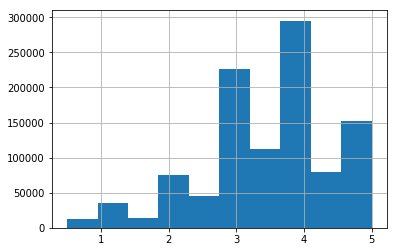

In [8]:
ratings['rating'].hist()

rating    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

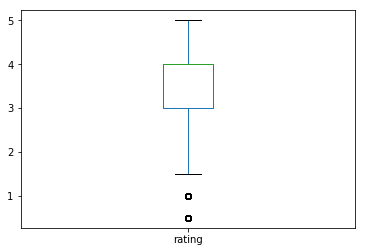

In [9]:
ratings['rating'].plot(kind='box', subplots=True)

#### Ratings group by
   Movie ratings aggregated by user:

In [10]:
userRatingsAggr = ratings.groupby(['userId']).agg({'rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr.head()

userId rating          
           size      mean
0      1  175.0  3.742857
1      2   61.0  4.000000
2      3  187.0  4.122995
3      4   28.0  3.571429
4      5   66.0  4.272727

In [11]:
userRatingsAggr['rating'].describe()

,size,mean
count,7120.000000,7120.000000
mean,147.271770,3.620345
std,220.808148,0.448493
min,20.000000,0.600000
25%,35.000000,3.360000
50%,69.000000,3.650000
75%,161.000000,3.922854
max,2711.000000,5.000000


#### Movie ratings aggregated by movie:

In [13]:
movieRatingsAggr = ratings.groupby(['movieId']).agg({'rating': [np.size, np.mean]})
movieRatingsAggr.reset_index(inplace=True)
movieRatingsAggr.head()

movieId  rating          
             size      mean
0       1  2569.0  3.959323
1       2  1155.0  3.268398
2       3   685.0  3.186861
3       4   138.0  3.000000
4       5   657.0  3.143836

In [14]:
movieRatingsAggr['rating'].describe()

,size,mean
count,14026.000000,14026.000000
mean,74.759375,3.214934
std,218.188441,0.790743
min,1.000000,0.500000
25%,2.000000,2.833333
50%,9.000000,3.363636
75%,43.000000,3.750000
max,3498.000000,5.000000


In [16]:
print(tags.shape)
tags.head(5)

(465564, 4)


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [17]:
print(movies.shape)
movies.head(5)

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Join movie rating data

In [18]:
movies = movies.merge(movieRatingsAggr, left_on='movieId', right_on='movieId', how='left')  # ['rating']
movies.columns = ['movieId', 'title', 'genres', 'rating_count', 'rating_avg']

In [19]:
movies.head(5)

,movieId,title,genres,rating_count,rating_avg
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.0,3.959323
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.0,3.268398
2,3,Grumpier Old Men (1995),Comedy|Romance,685.0,3.186861
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.0,3.000000
4,5,Father of the Bride Part II (1995),Comedy,657.0,3.143836


#### Get movie years from title

In [20]:
def getYear(title):
    result=re.search(r'\(\d{4}\)',title)
    if result:
        found=result.group(0).strip('(').strip(')')
    else:
        found=0
    return int(found)
movies['year']=movies.apply(lambda x:getYear(x['title']),axis=1)
movies.head(10)

,movieId,title,genres,rating_count,rating_avg,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.0,3.959323,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.0,3.268398,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,685.0,3.186861,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.0,3.000000,1995
4,5,Father of the Bride Part II (1995),Comedy,657.0,3.143836,1995
5,6,Heat (1995),Action|Crime|Thriller,1260.0,3.836508,1995
6,7,Sabrina (1995),Comedy|Romance,700.0,3.381429,1995
7,8,Tom and Huck (1995),Adventure|Children,78.0,3.352564,1995
8,9,Sudden Death (1995),Action,202.0,3.017327,1995
9,10,GoldenEye (1995),Action|Adventure|Thriller,1548.0,3.427003,1995


#### Create genres matrix - one hot encoding
At this step I create a "genresMatrix" field where every value is a list of binary values (19 elements in every list, for the 19 possible genres). For example a movie with genres "Action", "Adventure" and "Children" will look like: [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] . This transformation called as "one hot encoding".

This matrix will be very useful to define the similarities between two "genres" sets. For this purpose I'm going to compute the Cosine distance between the given arrays. More info: SciPy spatial.distance.cosine

In [21]:
genresList = [
  "Action",
  "Adventure",
  "Animation",
  "Children",
  "Comedy",
  "Crime",
  "Documentary",
  "Drama",
  "Fantasy",
  "Film-Noir",
  "Horror",
  "Musical",
  "Mystery",
  "Romance",
  "Sci-Fi",
  "Thriller",
  "War",
  "Western",
  "(no genres listed)"
]

#### one hot encoding of genre 

In [22]:
# how iterate over rows of dataframe:https://erikrood.com/Python_References/iterate_rows_pandas.html
def setGenresMatrix(genres):
    movieGenresMatrix = []
    movieGenresList = genres.split('|')
  
    for x in genresList:
        if (x in movieGenresList):
            movieGenresMatrix.append(1)
        else:
            movieGenresMatrix.append(0) 
    return movieGenresMatrix
    
movies['genresMatrix'] = movies.apply(lambda x: setGenresMatrix(x['genres']), axis=1)

movies.head(5)

,movieId,title,genres,rating_count,rating_avg,year,genresMatrix
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.0,3.959323,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.0,3.268398,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,685.0,3.186861,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.0,3.000000,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,5,Father of the Bride Part II (1995),Comedy,657.0,3.143836,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Set rating categories
Based on the number of user ratings per movie, I have defined 7 rating groups.

In [23]:
movieRatingsAggr['rating'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99])

,size,mean
count,14026.000000,14026.000000
mean,74.759375,3.214934
std,218.188441,0.790743
min,1.000000,0.500000
10%,1.000000,2.166667
20%,2.000000,2.666667
30%,3.000000,3.000000
40%,5.000000,3.166667
50%,9.000000,3.363636
60%,16.000000,3.500000


#### The desired rating number groups will be:

* 0 - not rated movie
* 1 - count of ratings between 1 - 10
* 2 - count of ratings between 11 - 30
* 3 - count of ratings between 31 - 100
* 4 - count of ratings between 101 - 300
* 5 - count of ratings between 301 - 1000
* 6 - count of ratings between 1001 -

In [24]:
def setRatingGroup(numberOfRatings):
    # if (numberOfRatings is None): return 0
    if (1 <= numberOfRatings <= 10): return 1
    elif (11 <= numberOfRatings <= 30): return 2
    elif (31 <= numberOfRatings <= 100): return 3
    elif (101 <= numberOfRatings <= 300): return 4
    elif (301 <= numberOfRatings <= 1000): return 5
    elif (1001 <= numberOfRatings): return 6
    else: return 0

movies['ratingGroup'] = movies.apply(lambda x: setRatingGroup(x['rating_count']), axis=1)
movies.fillna(0, inplace=True)  # Replace NaN values to zero

movies.head(10)

,movieId,title,genres,rating_count,rating_avg,year,genresMatrix,ratingGroup
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.0,3.959323,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",6
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.0,3.268398,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",6
2,3,Grumpier Old Men (1995),Comedy|Romance,685.0,3.186861,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.0,3.000000,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",4
4,5,Father of the Bride Part II (1995),Comedy,657.0,3.143836,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
5,6,Heat (1995),Action|Crime|Thriller,1260.0,3.836508,1995,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
6,7,Sabrina (1995),Comedy|Romance,700.0,3.381429,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5
7,8,Tom and Huck (1995),Adventure|Children,78.0,3.352564,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
8,9,Sudden Death (1995),Action,202.0,3.017327,1995,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
9,10,GoldenEye (1995),Action|Adventure|Thriller,1548.0,3.427003,1995,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


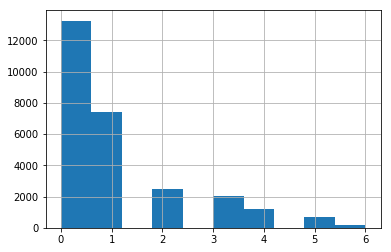

In [25]:
movies['ratingGroup'].hist()

### Removing Stop words

In [26]:
from nltk.corpus import stopwords

In [27]:
stop_words = list(stopwords.words('english'))
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Tags
Iterate through all the user given tags, split the tags into words, filter the defined stop words (frequent English words) and put the results into a dictionary that indexed by movieId.

In [28]:

tagsDict = {}

for index, x in tags.iterrows():
    wordlist = str(x['tag']).lower().split(' ')
    movieId = x['movieId']
    for y in wordlist:
        if y not in stop_words:
            if movieId in tagsDict:
                # if y not in tagsDict[movieId]:  # Switched off (we will get a non unique list)
                    tagsDict[movieId].append(y)
            else:
                tagsDict[movieId] = [y]

# tags.apply(lambda x: str(x['tag']).split(' '), axis=1)
print(tagsDict[4141])

['mark', 'waters', 'naive', 'mark', 'waters', 'freddie', 'prinze', 'jr.']


In [30]:
titleWordsDict = {}

for index, x in movies.iterrows():
    wordlist = str(x['title']).lower().split(' ')
    movieId = x['movieId']
    for y in wordlist:
        if y not in stop_words:
            if movieId in titleWordsDict:
                    titleWordsDict[movieId].append(y)
            else:
                titleWordsDict[movieId] = [y]

In [31]:
titleWordsDict[1]

['toy', 'story', '(1995)']

### Movie recommendation algorithm
The algorithm gets a "movieId" as input parameter and computes the similarity for every other movie in the dataset. To fine-tuning this process, we can set up weights for the 6 defined similarity attributes at the beginning of the code. At the end we just ordering the result set (the most similar movies will be at the beginning).

<img style="float: left;" src="download.png" >


In [41]:
#cosine distance:https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
#Algorithm source:https://www.kaggle.com/bakostamas/movie-recommendation-algorithm/notebook
# Parameter weights
genresSimilarityWeight = 0.8
tagsSimilarityWeight = 2
titleSimilarityWeight = 1
ratingAvgWeight = 0.2
ratingGroupWeight = 0.005
yearDistanceWeight = 0.1

def tagsSimilarity(basisMovieID, checkedMovieID, checkType):    
    # The higher value is the more similar (from 0 to 1) 
    #one hot encoding of tags and title of movies with the help of hash table
    if checkType == 'tag':
        dictToCheck = tagsDict
    else:
        dictToCheck = titleWordsDict
        
    counter = 0
    if basisMovieID in dictToCheck: 
        basisTags = dictToCheck[basisMovieID]
        countAllTags = len(basisTags)
        basisTagsDict = {}
        for x in basisTags:
            if x in basisTagsDict:
                basisTagsDict[x] += 1
            else:
                basisTagsDict[x] = 1   
        
        for x in basisTagsDict:
            basisTagsDict[x] = basisTagsDict[x] / countAllTags
    else: return 0
    
    if checkedMovieID in dictToCheck: 
        checkedTags = dictToCheck[checkedMovieID]
        checkedTags = set(checkedTags) # Make the list unique
        checkedTags = list(checkedTags)
        
    else: return 0
    
    for x in basisTagsDict:
        if x in checkedTags: counter += basisTagsDict[x]

    return counter
    
def checkSimilarity(movieId):
    print("SIMILAR MOVIES TO:")
    print (movies[movies['movieId'] == movieId][['movieId','title', 'rating_count', 'rating_avg']])
    basisGenres = np.array(list(movies[movies['movieId'] == movieId]['genresMatrix']))
   
    basisRatingAvg = movies[movies['movieId'] == movieId]['rating_avg']
    basisRatingGroup = movies[movies['movieId'] == movieId]['ratingGroup']
    
    moviesWithSim = movies
    moviesWithSim['similarity'] = moviesWithSim.apply(lambda x: 
                                                      spatial.distance.cosine(x['genresMatrix'], basisGenres) * genresSimilarityWeight   
                                                      - tagsSimilarity(movieId, x['movieId'], 'tag') * tagsSimilarityWeight 
                                                      - tagsSimilarity(movieId, x['movieId'], 'title') * titleSimilarityWeight +
                                                      abs(basisRatingAvg - x['rating_avg']) * ratingAvgWeight +
                                                      abs(basisRatingGroup - x['ratingGroup']) * ratingGroupWeight 
                                                  
                                                     , axis=1)
    
    moviesWithSim = moviesWithSim.loc[(moviesWithSim.movieId != movieId)]
    return moviesWithSim[['movieId', 'title', 'genres', 'rating_count', 'rating_avg', 'similarity']].sort_values('similarity')


* <img style="float: left;" src="https://movieposters2.com/images/1125336-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">X-men</span>

In [43]:
# X-men
similarityResult  = checkSimilarity(3793)
similarityResult.head(5)

SIMILAR MOVIES TO:
      movieId         title  rating_count  rating_avg
3702     3793  X-Men (2000)        1422.0    3.602672


,movieId,title,genres,rating_count,rating_avg,similarity
6234,6333,X2: X-Men United (2003),Action|Adventure|Sci-Fi|Thriller,847.0,3.656434,-2.016412
13677,68319,X-Men Origins: Wolverine (2009),Action|Sci-Fi|Thriller,141.0,3.241135,-1.162735
7953,8636,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX,858.0,3.552448,-1.151231
11020,45499,X-Men: The Last Stand (2006),Action|Sci-Fi|Thriller,305.0,3.355738,-1.060679
5252,5349,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller,1256.0,3.547771,-1.043433


<img style="float: left;" src="https://movieposters2.com/images/744898-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">Lock, Stock & Two Smoking Barrels</span>

In [34]:
# Lock, Stock & Two Smoking Barrels
similarityResult  = checkSimilarity(2542)
similarityResult.head(5)

SIMILAR MOVIES TO:
                                         title  rating_count  rating_avg
2457  Lock, Stock & Two Smoking Barrels (1998)         809.0    4.007417


,movieId,title,genres,rating_count,rating_avg,similarity
3917,4011,Snatch (2000),Comedy|Crime|Thriller,899.0,4.064516,-1.484849
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,3498.0,4.153516,-1.060093
1672,1732,"Big Lebowski, The (1998)",Comedy|Crime,1102.0,3.941470,-0.802492
1067,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,1414.0,4.062942,-0.732154
12412,57669,In Bruges (2008),Comedy|Crime|Drama|Thriller,242.0,3.894628,-0.727203


<img style="float: left;" src="https://movieposters2.com/images/750888-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">Iron Man</span>

In [44]:
# Iron Man
similarityResult  = checkSimilarity(59315)
similarityResult.head(5)

SIMILAR MOVIES TO:
       movieId            title  rating_count  rating_avg
12631    59315  Iron Man (2008)         593.0    3.960371


,movieId,title,genres,rating_count,rating_avg,similarity
15203,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,224.0,3.582589,-1.687626
20906,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX,91.0,3.675824,-1.521496
17874,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,249.0,3.947791,-1.224368
12742,60040,"Incredible Hulk, The (2008)",Action|Sci-Fi,131.0,3.339695,-1.077685
12409,57640,Hellboy II: The Golden Army (2008),Action|Adventure|Fantasy|Sci-Fi,116.0,3.366379,-0.624094


<img style="float: left;" src="https://movieposters2.com/images/660783-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">Star Wars: Episode IV - A new hope</span>

In [45]:
# Star Wars: Episode IV - A New Hope
similarityResult  = checkSimilarity(260)
similarityResult.head(5)

SIMILAR MOVIES TO:
     movieId                                      title  rating_count  \
257      260  Star Wars: Episode IV - A New Hope (1977)        2874.0   

     rating_avg  
257    4.189457  


,movieId,title,genres,rating_count,rating_avg,similarity
1171,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,2418.0,4.163358,-2.023602
1184,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,2480.0,3.992339,-2.009448
10117,33493,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi,652.0,3.464724,-1.339193
2543,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,1583.0,3.083702,-1.289709
5281,5378,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,892.0,3.117713,-1.273132


<img style="float: left;" src="https://movieposters2.com/images/645250-b.jpg" width="280" height="400">
<span style="font-size:200%;margin:20px;">Cars</span>

In [46]:
# Cars
similarityResult  = checkSimilarity(45517)
similarityResult.head(5)

SIMILAR MOVIES TO:
       movieId        title  rating_count  rating_avg
11026    45517  Cars (2006)         235.0    3.434043


,movieId,title,genres,rating_count,rating_avg,similarity
17425,87876,Cars 2 (2011),Adventure|Animation|Children|Comedy|IMAX,17.0,3.323529,-0.902940
22893,109420,Mater and the Ghostlight (2006),Animation|Children|Comedy,2.0,4.000000,-0.700697
11016,45431,Over the Hedge (2006),Adventure|Animation|Children|Comedy,114.0,3.355263,-0.679287
2270,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,1075.0,3.582326,-0.599830
4790,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1256.0,3.865844,-0.567762


<img style="float: left;" src="Toy_Story.jpg" >
<span style="font-size:200%;margin:20px;">Toy Story</span>

In [47]:
# Toy Story
similarityResult  = checkSimilarity(1)
similarityResult.head(5)

SIMILAR MOVIES TO:
   movieId             title  rating_count  rating_avg
0        1  Toy Story (1995)        2569.0    3.959323


,movieId,title,genres,rating_count,rating_avg,similarity
3027,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1180.0,3.854237,-2.089097
15401,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,306.0,4.042484,-1.869451
4790,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1256.0,3.865844,-1.141089
4211,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,1696.0,3.829894,-1.132418
6271,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,1224.0,3.863562,-1.052584


<img style="float: left;" src="Pirates_of_the_caribbean_2_poster_b.jpg" >
<span style="font-size:200%;margin:20px;">Pirates of Caribbean</span>

In [60]:
# Pirates of Caribbean
similarityResult  = checkSimilarity(45722)
similarityResult.head(10)

SIMILAR MOVIES TO:
       movieId                                              title  \
11055    45722  Pirates of the Caribbean: Dead Man's Chest (2006)   

       rating_count  rating_avg  
11055         503.0    3.472167  


,movieId,title,genres,rating_count,rating_avg,similarity
11873,53125,Pirates of the Caribbean: At World's End (2007),Action|Adventure|Comedy|Fantasy,290.0,3.431034,-1.928567
6429,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,1317.0,3.884966,-1.749968
17189,86880,Pirates of the Caribbean: On Stranger Tides (2...,Action|Adventure|Fantasy|IMAX,69.0,3.253623,-1.090051
5853,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,1794.0,4.106187,-0.337507
4897,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,1990.0,4.140201,-0.297529
7041,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,1619.0,4.126621,-0.287735
14937,74789,Alice in Wonderland (2010),Adventure|Fantasy|IMAX,142.0,3.190141,-0.270465
21237,103384,"Lone Ranger, The (2013)",Action|Adventure|Western|IMAX,12.0,3.166667,-0.268608
22116,106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX,73.0,3.561644,-0.256582
11878,53138,"Librarian: Return to King Solomon's Mines, The...",Action|Adventure|Fantasy,8.0,3.250000,-0.249153


<img style="float: left;" src="Harry_Potter_and_the_Philosopher's_Stone_banner.jpg" >
<span style="font-size:200%;margin:20px;">Harry_Potter_and_the_Philosopher's_Stone</span>

In [63]:
# Harry potter
similarityResult  = checkSimilarity(4896)
similarityResult.head(10)

SIMILAR MOVIES TO:
      movieId                                              title  \
4800     4896  Harry Potter and the Sorcerer's Stone (a.k.a. ...   

      rating_count  rating_avg  
4800         918.0    3.574619  


,movieId,title,genres,rating_count,rating_avg,similarity
5717,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,748.0,3.549465,-1.667358
10600,40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX,519.0,3.710019,-1.550698
7769,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,693.0,3.738095,-1.457876
11974,54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX,322.0,3.703416,-1.274241
13935,69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX,234.0,3.826923,-1.263995
16191,81834,Harry Potter and the Deathly Hallows: Part 1 (...,Action|Adventure|Fantasy|IMAX,190.0,3.844737,-1.246027
17499,88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX,200.0,3.942500,-0.939592
4897,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,1990.0,4.140201,-0.936091
10643,41566,"Chronicles of Narnia: The Lion, the Witch and ...",Adventure|Children|Fantasy,361.0,3.400277,-0.924728
2077,2161,"NeverEnding Story, The (1984)",Adventure|Children|Fantasy,554.0,3.537906,-0.714880
